In [1]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/gmm_ubm/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
# test for gmm-ubm
from importlib import reload
from audio_datastore.audio_datastore import AudioDatastore
import audio_datastore.audio_datastore as myads
reload(myads)
from collections import Counter
from importlib import reload
from audio_datastore.audio_datastore import AudioDatastore
import os.path
from collections import Counter
import random
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from spafe.utils import vis
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, _gaussian_mixture
import numpy as np
from scipy.special import logsumexp

In [3]:
datasetFolder = r"/Users/david/Documents/data/speech/google_speech/test"
ads = AudioDatastore()
ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
ads = myads.subset(ads, label='stop')

In [4]:
speakers = []
for file in ads.files:
    nm = os.path.basename(file)
    nm = nm.split('_')[0]
    speakers.append('a' + nm)
ads.set(labels=speakers)

In [5]:
num_speakers_to_enroll = 10
label_count = Counter(ads.labels)
for_enroll_and_test_set = []
for key, cnts in list(label_count.items()):
    if cnts >= 3:
        for_enroll_and_test_set.append(key)
for_enroll = for_enroll_and_test_set[0:num_speakers_to_enroll]
ads_enroll_and_validate = myads.subset(ads, label=for_enroll)
ads_enroll, ads_test = myads.split(ads_enroll_and_validate, 2)

ads_train_ubm = myads.filter(ads, ads_test.files)
ads_train_ubm = myads.filter(ads_train_ubm, ads_enroll.files)

# ads_norm, _ = myads.split(ads, 2)

In [6]:
import feature_extraction.fe_spafe.fe_spafe as fe_spafe
import feature_extraction.fe_base as fe_base
import classifiers.classifier_base as classifier_base
import classifiers.gmm_ubm.classifier_gmm_ubm as classifier_gmm_ubm
import processing.process_method_base as process_method_base
import processing.processing as processing
reload(fe_base)
reload(fe_spafe)
reload(classifier_base)
reload(classifier_gmm_ubm)
reload(process_method_base)
reload(processing)

<module 'processing.processing' from '/Users/david/Documents/mastersCode/ubm/processing/processing.py'>

In [7]:
import torch
torch.set_num_threads(1)
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)
(get_speech_timestamps,
 _, read_audio,
 *_) = utils

Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /Users/david/.cache/torch/hub/master.zip


testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 40
reverb False


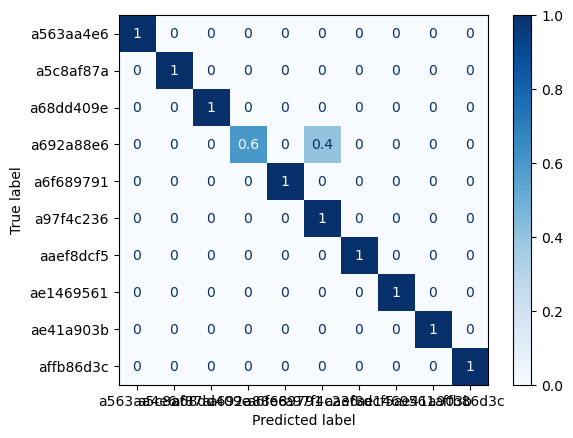

testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 15
reverb False


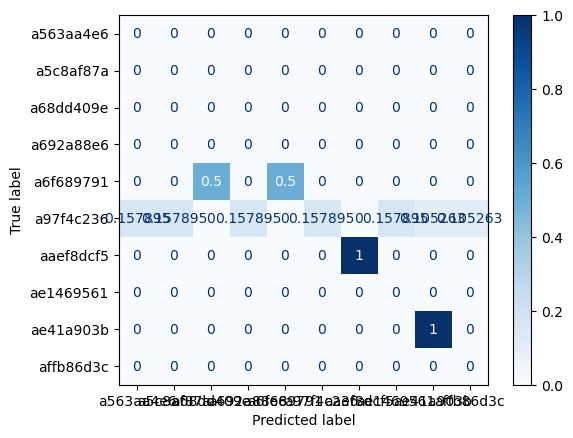

testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 5
reverb False


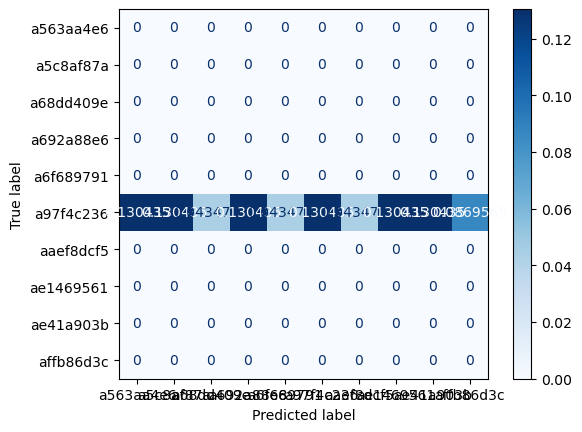

testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 40
reverb True


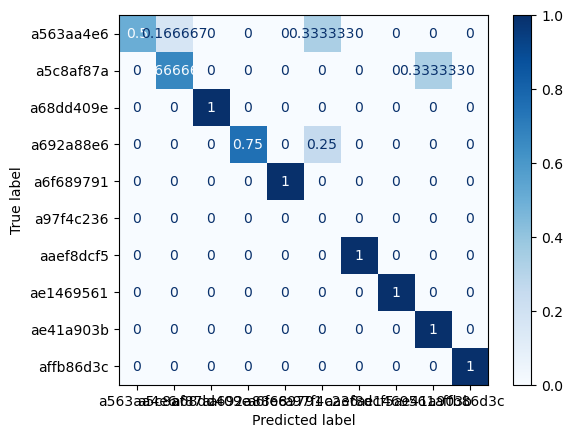

testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 15
reverb True


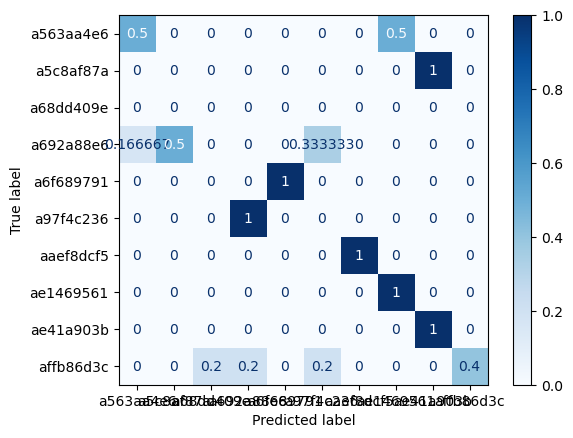

testing for: spafe.features.mfcc.mfcc ClassifierGMMUBM
snr_db: 5
reverb True


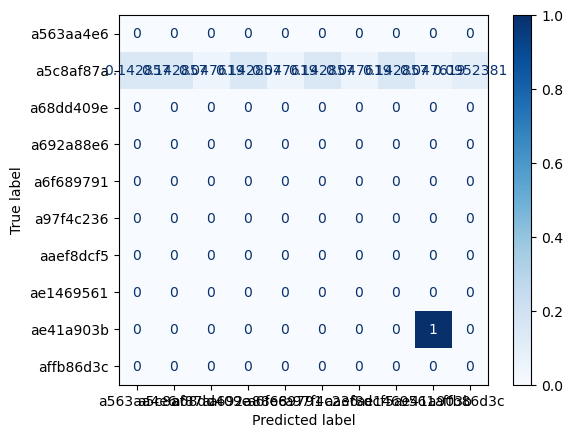

In [8]:
# processing
process_methods = [
    process_method_base.ProcessMethodBase(snr_db=40, reverb=False,model=model, get_speech_timestamps=get_speech_timestamps),
    process_method_base.ProcessMethodBase(snr_db=15, reverb=False,
    model=model, get_speech_timestamps=get_speech_timestamps),
    process_method_base.ProcessMethodBase(snr_db=5, reverb=False,
    model=model, get_speech_timestamps=get_speech_timestamps),
    process_method_base.ProcessMethodBase(snr_db=40, reverb=True,
    model=model, get_speech_timestamps=get_speech_timestamps),
    process_method_base.ProcessMethodBase(snr_db=15, reverb=True,model=model, get_speech_timestamps=get_speech_timestamps),
    process_method_base.ProcessMethodBase(snr_db=5, reverb=True,model=model, get_speech_timestamps=get_speech_timestamps),
]

fe_methods = [
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
    fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC),
]

classifiers = {}
for i in range(len(fe_methods)):
    classifier = classifier_gmm_ubm.ClassifierGMMUBM(fe_methods[i], process_methods[i])
    classifier.set_normalisation(ads_enroll)
    classifier.train(ads_train=ads_train_ubm)
    classifier.enroll(ads_enroll)
    classifier.test_all(ads_test)

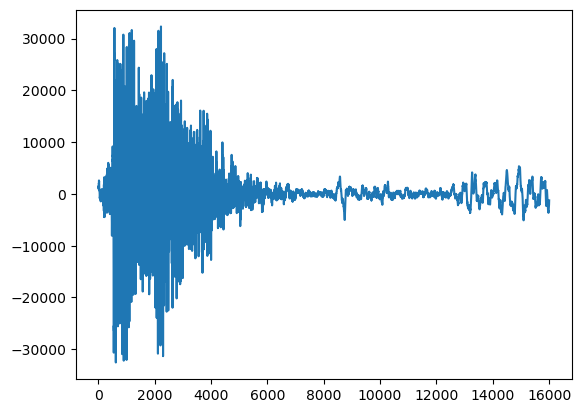

In [24]:
# '9d4bab4f_nohash_1.wav'

_, sound = wav.read(ads.files[9])
plt.plot(sound)